# Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks

The article is available at https://arxiv.org/pdf/1703.03400.pdf.

MAML algorithm aims to deep train a network to make it able to learn a new task very fast. The idea is to have a maximal performance with a few gradient steps (one or more) and a small amount of data when we give it a new model to learn. It is agnostic, meaning that it can be applied to any learning problem as far as it is trained with a gradient descent procedure. MAML can be used for regression, classification and reinforcement learning.

A good example for illustrating MAML purpose in the article was a classification problem: the recognition of a segway image. With MAML, we'll train the network with a lot of different types of images, and then it will be able to recognize a segway after seing only a few examples. 

In this notebook, we'll study only regression case, with the example of the sine wave. If the first part, we define the parameters and data generator. Then, we will build two networks: a classic neural network and MAML, to compare their performance at the end.

For experiments developped in the article, another way of coding MAML has been implemented in python (it is more general but also more complicated to understand). It is available at github.com/cbfinn/maml and github.com/cbfinn/maml_rl for reinforcment learning.

### Imports and classes definitions

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend


# Other dependencies
import random
import sys

import numpy as np
import matplotlib.pyplot as plt


We define the train and test data generator with the class $SinusoidGenerator$. It creates a sine function with random amplitude $ A \in [0.1, 5.0]$ and a random phase $ \omega \in [0, \pi]$. The parameters $K$ is the number of random datapoints used for training the model on this function. In the article, they used $K = 10$ for training.

The data function is $f(x) = A*\sin(x - \omega)$


In [ ]:
class SinusoidGenerator():

    def __init__(self):

        self.K = 10
        self.amplitude = np.random.uniform(0.1, 5.0)
        self.phase = np.random.uniform(0, np.pi)
    
    def f(self, x):
        return self.amplitude * np.sin(x - self.phase)

    def x_y_sample(self, x = None):
        if x is None:
            x = np.random.uniform(-5, 5, self.K)
        y = self.f(x)
        return x[:, None], y[:, None]
    


Let's create a training dataset made of 10 000 $SinusoidGenerator$ objects. 

In [ ]:

train_ds = [SinusoidGenerator() for i in range(10000)]


Let's now create the neural network that will learn sine recognition. Input($x$) and ouput ($f(x)$) both have a dimention of $1$. The network has two hidden layers of shape $40$ and the activation function is $relu$. Those parameters were specified in the article.

In [ ]:
class SineModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden1 = keras.layers.Dense(40, input_shape=(1,))
        self.hidden2 = keras.layers.Dense(40)
        self.out = keras.layers.Dense(1)
        
    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x


#### Classic neural network

For training the network to recognize a sine function, we use MSE as loss function, Adam as optimizer and the gradient descent as criteria for the optimizer. At each step of the training, a new $SinusoidGenerator$ sample is used. It is trained once with a sample of $K$ random datapoints.

In [ ]:
def loss_function(pred_y, y):
  return keras_backend.mean(keras.losses.mean_squared_error(y, pred_y))

    
def train_sample(x, y, model, optimizer):
    tensor_x, tensor_y = tf.convert_to_tensor((x, y))
    with tf.GradientTape() as tape:
        mse = loss_function(y, model.forward(x))
    gradients= tape.gradient(mse, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return mse




In [ ]:
def train_model(model, dataset, lr=0.001):
   
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    total_loss = 0
    
    for i, sine_wave in enumerate(dataset):
        x, y = sine_wave.x_y_sample()
        loss = train_sample(x, y, model, optimizer)

        total_loss += loss
        curr_loss = total_loss / (i + 1.0)
        
        if i % 1000 == 0 :
            print('Step', i, ': loss =', curr_loss.numpy())

            plt.scatter(x, y, c = 'blue')

            x_test= np.arange(-5,5,step = 0.5)
            x_test = x_test.reshape(x_test.shape[0], 1)
            plt.scatter(x_test, model.forward(x_test), c='orange')

            x_linspace = np.linspace(-5,5,101)
            plt.plot(x_linspace, sine_wave.f(x_linspace), c='blue')
            plt.show() 


Now we can create a neural network and train it with the training dataset. We are supposed to get a decresasing loss and to have outputs (onge dots on the plots) closer and closer to the average $SinusoidGenerator$, with $A = 2.5$ and $\omega = \pi/2$

Step 0 : loss = 4.080223158214326


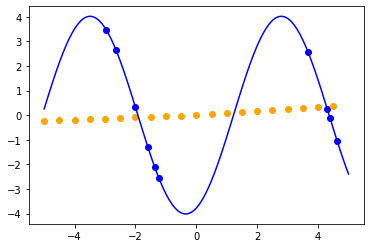

Step 1000 : loss = 3.6567794593863656


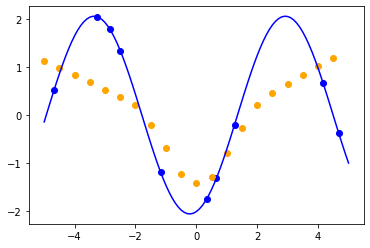

Step 2000 : loss = 3.521057049370144


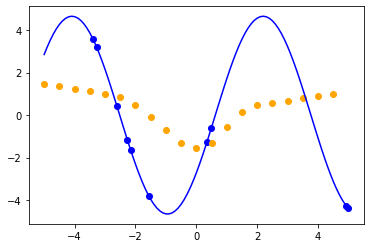

Step 3000 : loss = 3.4103777711446006


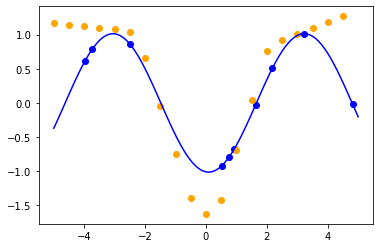

Step 4000 : loss = 3.4008785877651455


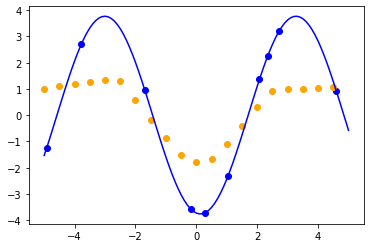

Step 5000 : loss = 3.380935228625245


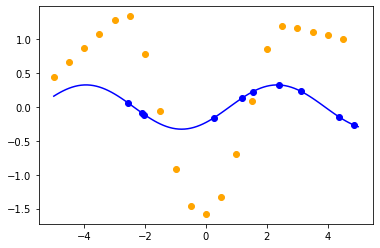

Step 6000 : loss = 3.345618444371667


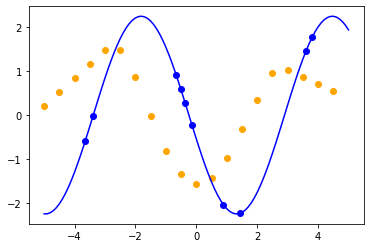

Step 7000 : loss = 3.3021360105126476


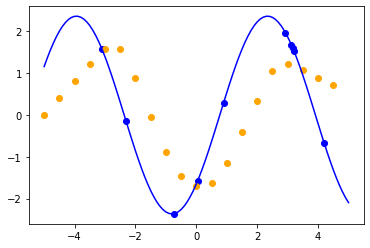

Step 8000 : loss = 3.2620289406109575


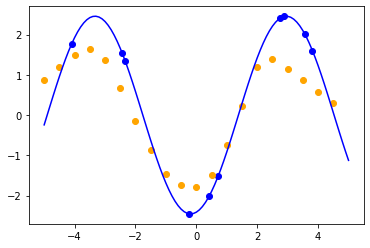

Step 9000 : loss = 3.2316432882317416


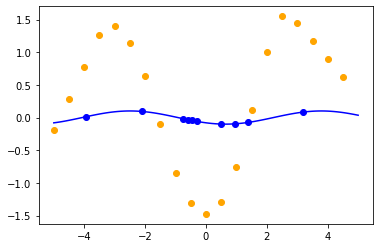

In [ ]:
neural_net = SineModel()
train_model(neural_net, train_ds)

### MAML


We can define the MAML training function for a similar neural network. The loss function is still MSE but now, at each step we do not try to minimize the current MSE but a "fake" MSE defined as the MSE the model would return if we trained it with the current training data. MAML anticipates the loss when training a new tasks and the purpose is minimizing that loss.

To compute a fake task learning without modifying the model, we need to use a copy the model at each step to train a new sine function. Let's first define a function to copy the model, which build a new $SineModel$ object and then gets ans copies the model weights.

In [ ]:
def copy_model(model, x):

    copied_model = SineModel()
    copied_model.forward(tf.convert_to_tensor(x))
    copied_model.set_weights(model.get_weights())
    
    return copied_model


With the MAML algorithm below, we can define the training function for MAML.



<div class="alert alert-success">

**MAML for Few-Shot Supervized Learning:**
<ol style="list-style-type:none">
<li> Input $p(T)$: distribution over tasks (here, sine wave)
<li> Input $\alpha, \beta$: step size hyperparameters (here, learning rate = 0.001)
<li> Randomly inilialize $\theta$
<li> while not done do:
    <ol style="list-style-type:none">
    <li> Sample batch of tasks $T_i \mathtt{\sim}p(T)$ (here, train_data)
    <li> for all $\tau_i$ do:
      <ol style="list-style-type:none">
      <li> Sample $K$ datapoints $D = {x^j, y^j}$ from $T_i$, 
      <li> Evaluate $\nabla_\theta L_{T_i}(f_\theta)$ using $D$ and $L_{T_i}$
      <li> Compute adapted parameters with gradient descent : $\theta_i' \leftarrow \theta - \alpha \nabla_{\theta}L_{T_i}(f_\theta)$
      <li> Sample datapoints $D_i' = {x^j, y^j}$ from $T_i$ for the meta-update
      </ol>
    <li> end for 
    <li> Update $\theta \leftarrow \theta - \beta \nabla_{\theta} \sum\limits_{T_i \mathtt{\sim} p(T)}L_{T_i}(f_{\theta_i'})$ using each $D_i'$ and $L_{T_i}$
    </ol>
<li>end while
</ol>


In [ ]:
def train_maml(model, dataset, epochs=1, lr_inner=0.01, batch_size=1, log_steps=1000):

    optimizer = keras.optimizers.Adam()
 
    for epoch in range(epochs):

        total_loss = 0

        for i, sine_wave in enumerate(dataset):

            x, y = tf.convert_to_tensor(sine_wave.x_y_sample())
            y_pred = model.forward(x)  # run forward pass to initialize weights


            with tf.GradientTape() as test_tape:
                
                with tf.GradientTape() as train_tape:
                    train_loss = loss_function(y, model.forward(x))

                gradients = train_tape.gradient(train_loss, model.trainable_variables)
                k = 0

                fake_model = copy_model(model, x)

                for j in range(len(fake_model.layers)):

                    new_kernel = tf.subtract(model.layers[j].kernel, tf.multiply(lr_inner, gradients[k]))
                    new_biases = tf.subtract(model.layers[j].bias,  tf.multiply(lr_inner, gradients[k+1]))
                     
                    fake_model.layers[j].kernel = new_kernel
                    fake_model.layers[j].bias = new_biases
                    k += 2

                fake_y_pred = fake_model.forward(x)
                test_loss = loss_function(y, fake_y_pred)

            gradients = test_tape.gradient(test_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            total_loss += test_loss
            loss = total_loss / (i+1.0)
            
            if i % 100 == 0 and i > 0:
                print('Step {}: loss = {}'.format(i, loss))

                plt.scatter(x, y)

                truc= np.arange(-5,5,step = 0.5)
                truc = truc.reshape(truc.shape[0], 1)
                plt.scatter(truc, model.forward(truc))


                x_linspace = np.linspace(-5,5,101)
                plt.plot(x_linspace, sine_wave.f(x_linspace))
                plt.show() 
    

Let's create a new neural network with $SineModel$ and train it.

Step 100: loss = 3.307236478099928


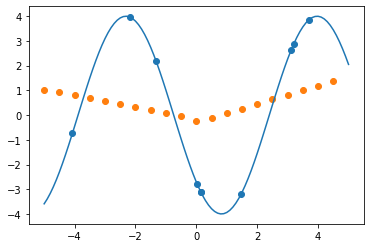

Step 200: loss = 3.045035668707492


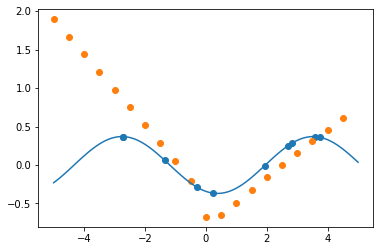

Step 300: loss = 3.200523475898105


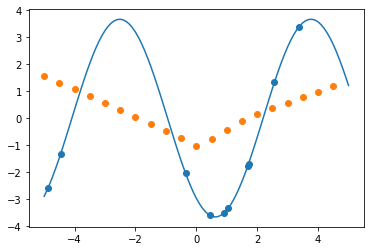

Step 400: loss = 3.0794410409353943


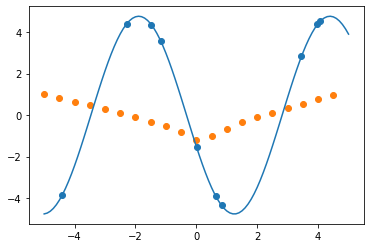

Step 500: loss = 3.0299694726680544


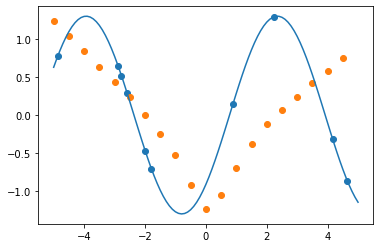

Step 600: loss = 2.944721357178424


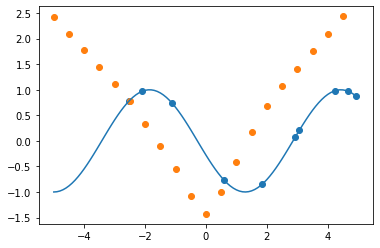

Step 700: loss = 2.9190756844212555


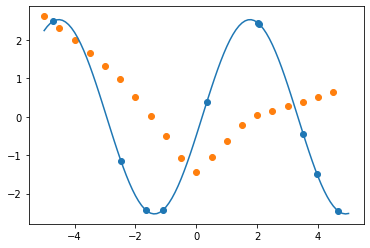

Step 800: loss = 2.8568450003657038


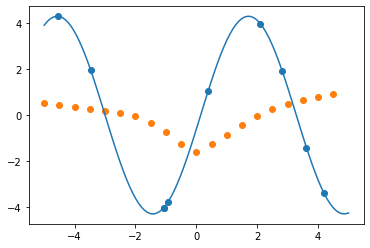

Step 900: loss = 2.8550748201214806


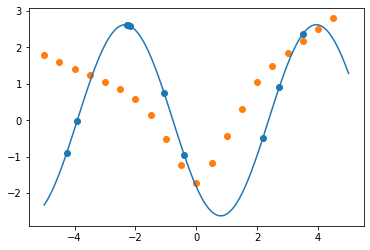

Step 1000: loss = 2.751444996317872


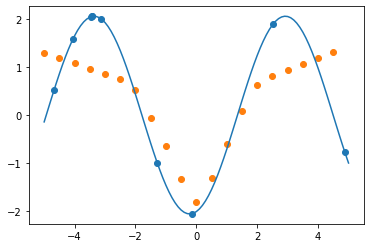

Step 1100: loss = 2.7030416857456956


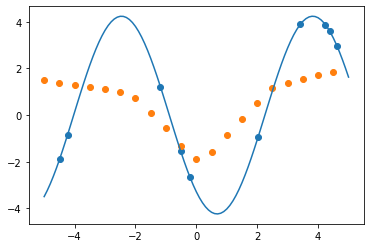

Step 1200: loss = 2.6492913443126085


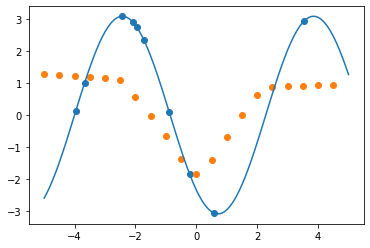

Step 1300: loss = 2.5993364407307347


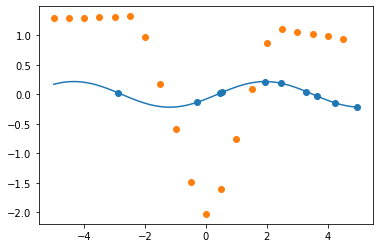

Step 1400: loss = 2.5618021244077807


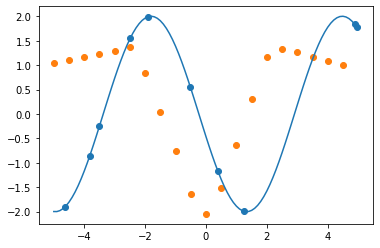

Step 1500: loss = 2.5069446136389644


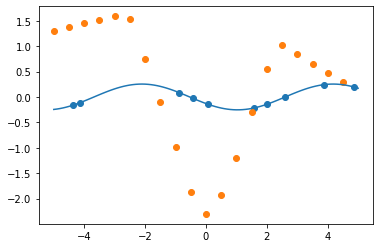

Step 1600: loss = 2.4467946186133482


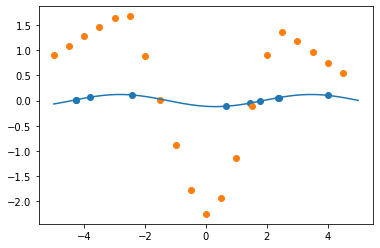

Step 1700: loss = 2.385300934294092


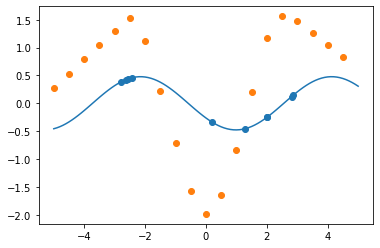

Step 1800: loss = 2.3497528840020876


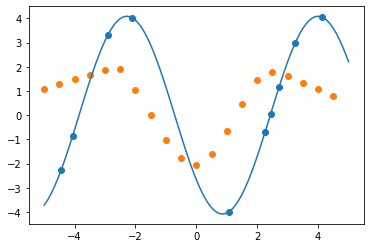

Step 1900: loss = 2.293915425764639


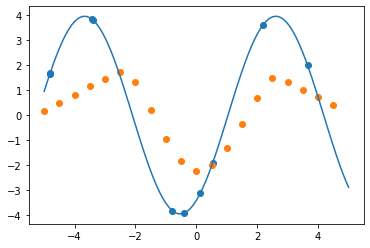

Step 2000: loss = 2.2440897692445296


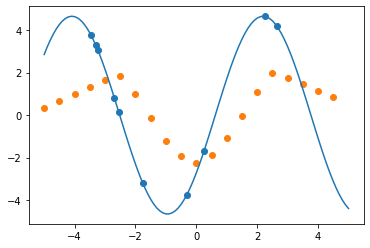

Step 2100: loss = 2.1870825156000206


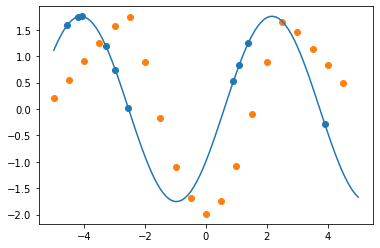

Step 2200: loss = 2.1468715566908365


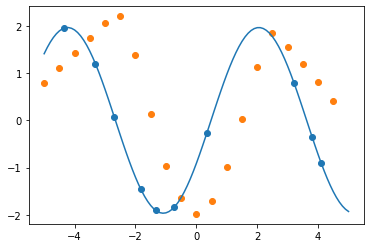

Step 2300: loss = 2.113093943237164


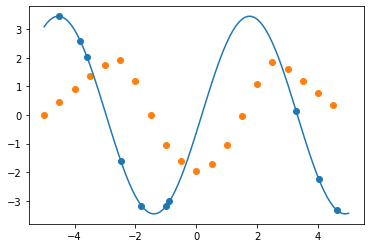

Step 2400: loss = 2.068932163238293


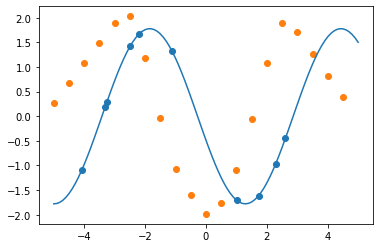

Step 2500: loss = 2.021386704573803


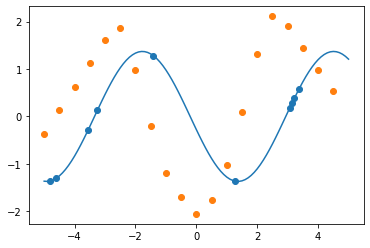

Step 2600: loss = 1.9991426251613678


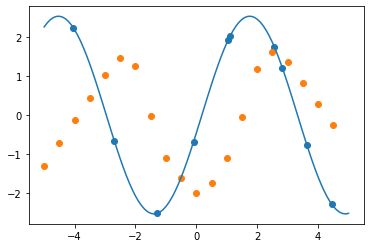

Step 2700: loss = 1.9730490369956837


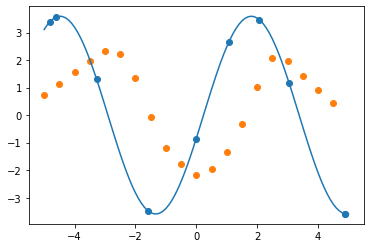

Step 2800: loss = 1.9458534284977644


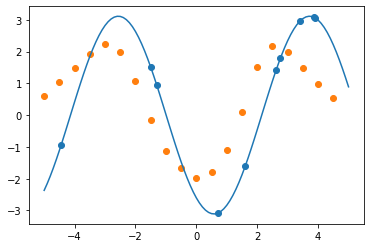

Step 2900: loss = 1.9151726034707246


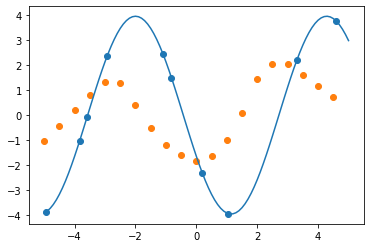

Step 3000: loss = 1.878275719115818


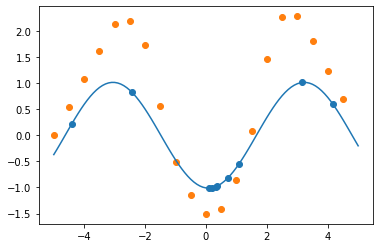

Step 3100: loss = 1.857462705948661


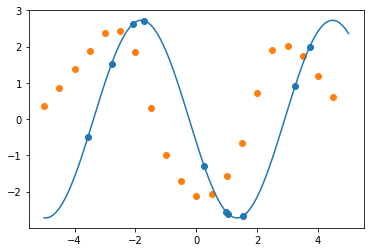

Step 3200: loss = 1.8298184392519785


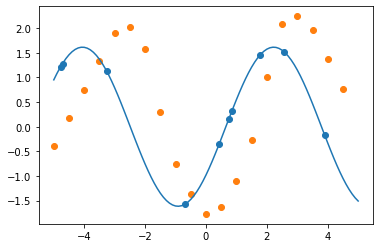

Step 3300: loss = 1.7978550775109112


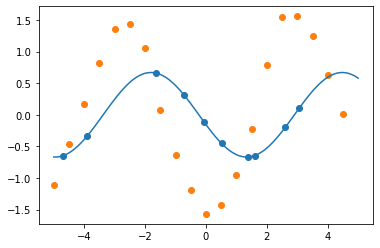

Step 3400: loss = 1.7757141473442384


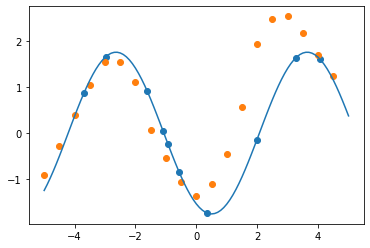

Step 3500: loss = 1.7536414576279873


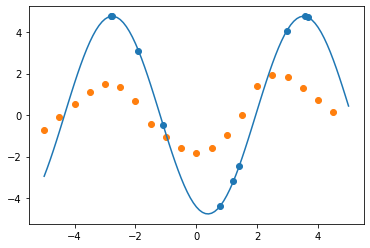

Step 3600: loss = 1.7249870519590766


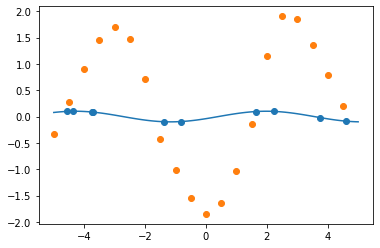

Step 3700: loss = 1.705479437896536


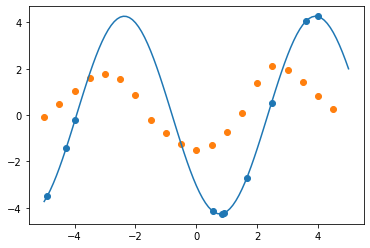

Step 3800: loss = 1.6817126507171272


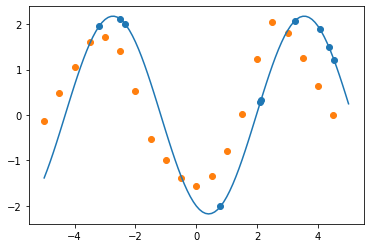

Step 3900: loss = 1.65889786736101


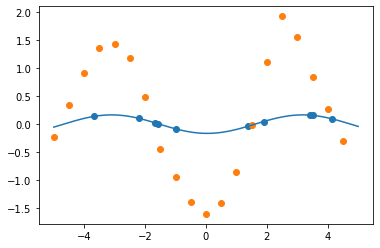

Step 4000: loss = 1.633661210007705


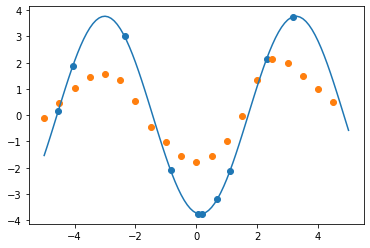

Step 4100: loss = 1.6106589502367188


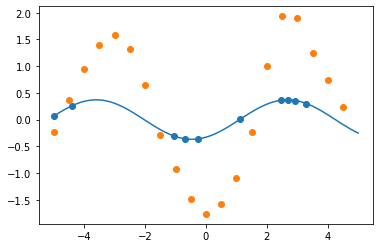

Step 4200: loss = 1.590216568202578


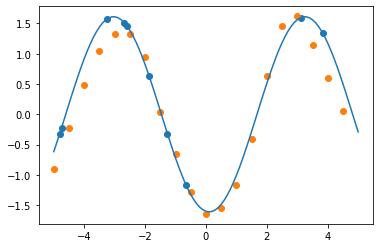

Step 4300: loss = 1.5677884357811371


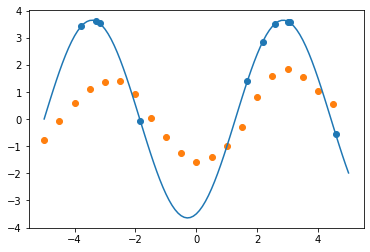

Step 4400: loss = 1.5469265064347444


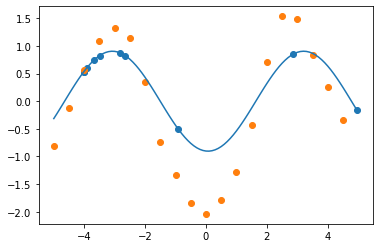

Step 4500: loss = 1.5301645184885004


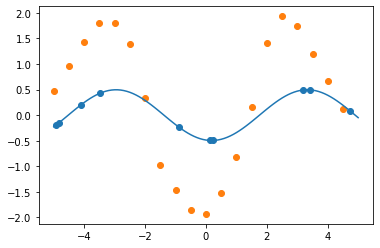

Step 4600: loss = 1.5115351917981357


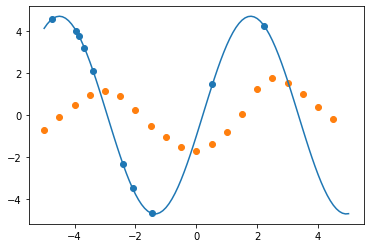

Step 4700: loss = 1.4913746865481523


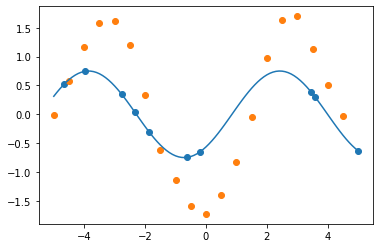

Step 4800: loss = 1.473723475976527


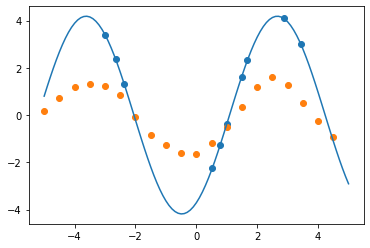

Step 4900: loss = 1.4573921285167868


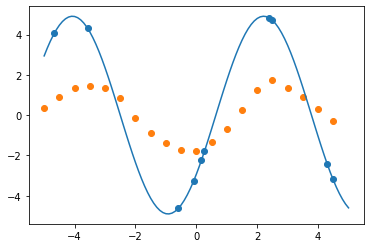

Step 5000: loss = 1.4429666093917712


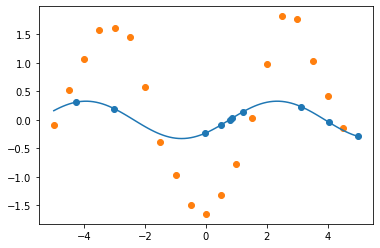

Step 5100: loss = 1.4259008321211324


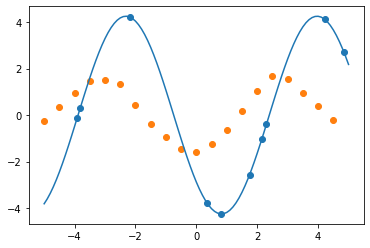

Step 5200: loss = 1.4111687894318266


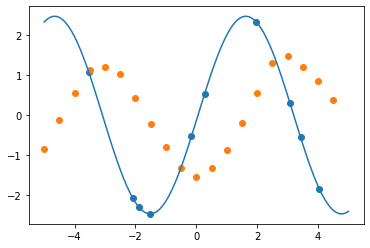

Step 5300: loss = 1.397403661025724


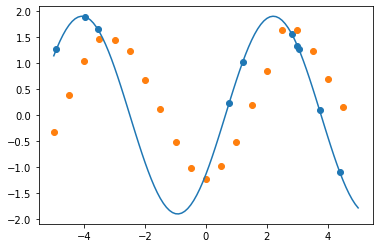

Step 5400: loss = 1.3828197214232605


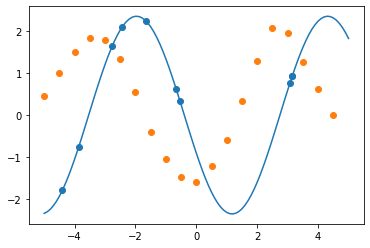

Step 5500: loss = 1.3699869754886143


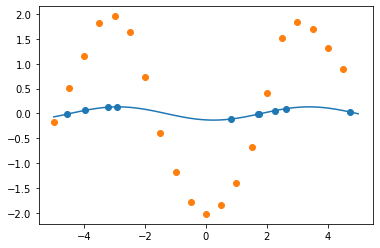

Step 5600: loss = 1.3569961900068164


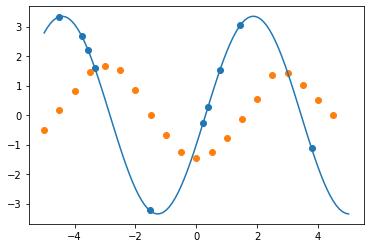

Step 5700: loss = 1.342562199794602


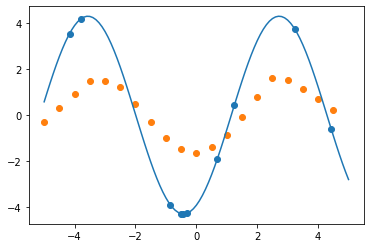

Step 5800: loss = 1.328147696775506


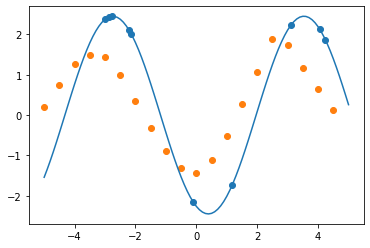

Step 5900: loss = 1.314927740826504


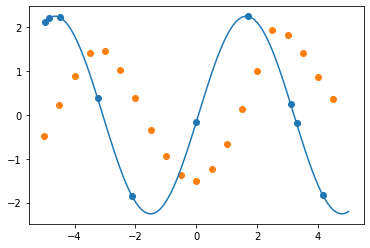

Step 6000: loss = 1.3015732582952424


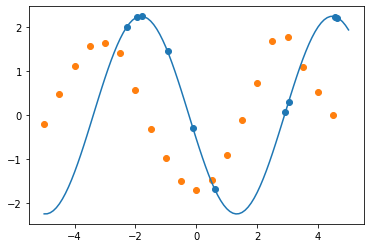

Step 6100: loss = 1.289080070783795


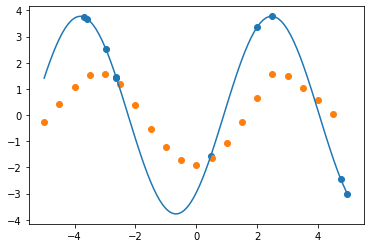

Step 6200: loss = 1.2763638364201617


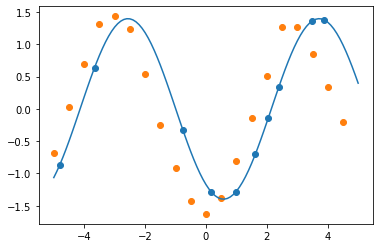

Step 6300: loss = 1.2645421549379359


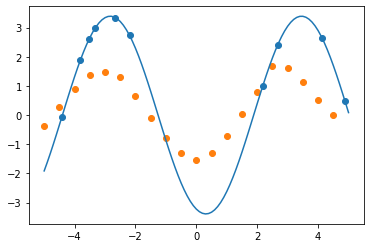

Step 6400: loss = 1.2518900593358675


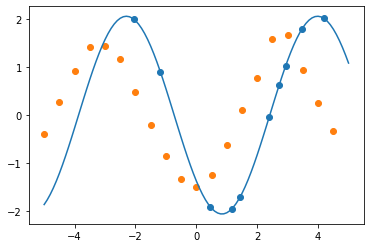

Step 6500: loss = 1.239767959459551


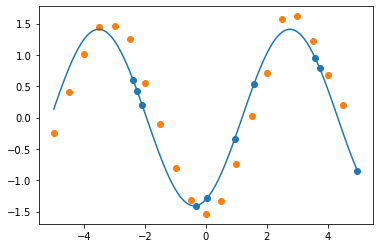

Step 6600: loss = 1.2279260699117978


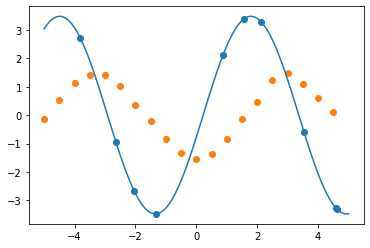

Step 6700: loss = 1.220045209271553


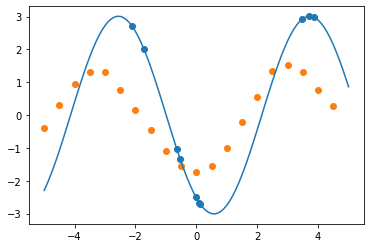

Step 6800: loss = 1.2104666685362724


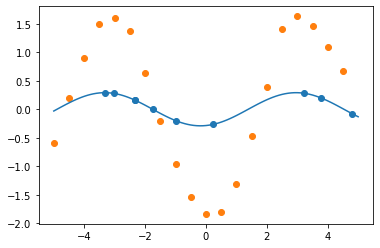

Step 6900: loss = 1.201419606360414


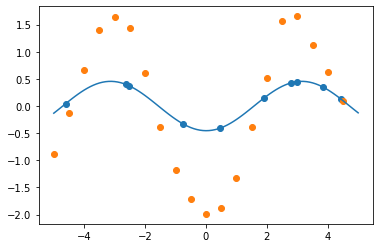

Step 7000: loss = 1.1915072241085454


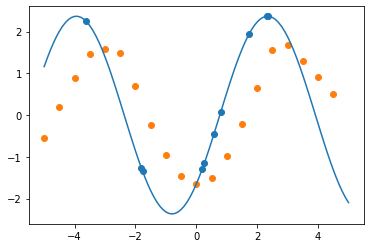

Step 7100: loss = 1.181376898246443


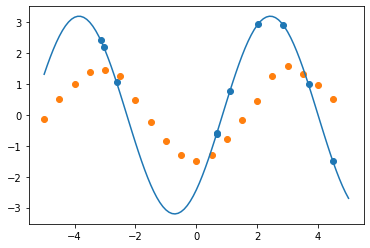

Step 7200: loss = 1.173050975276552


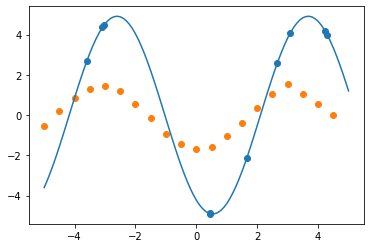

Step 7300: loss = 1.1644751196551366


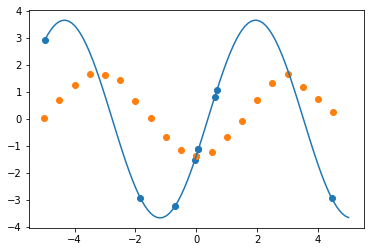

Step 7400: loss = 1.1557495087169636


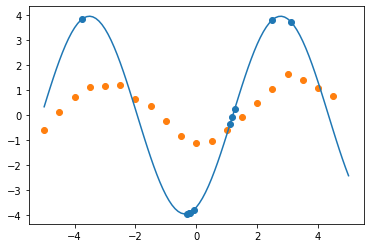

Step 7500: loss = 1.1463670365246137


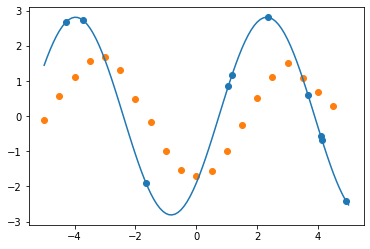

Step 7600: loss = 1.137741409966544


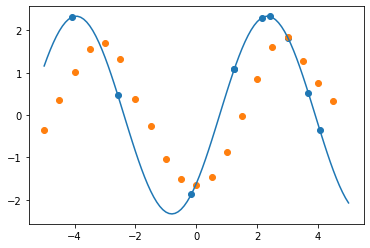

Step 7700: loss = 1.1279961743580533


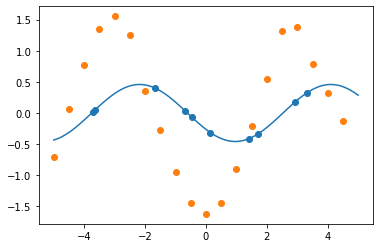

Step 7800: loss = 1.1214215602602533


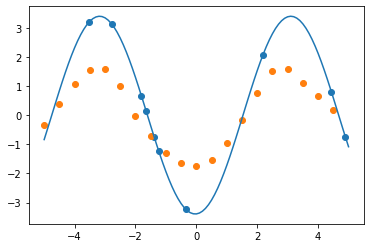

Step 7900: loss = 1.1141373720136825


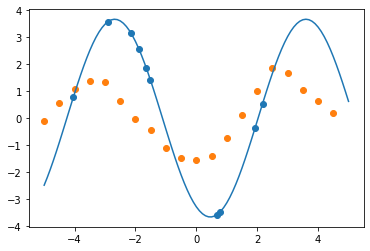

Step 8000: loss = 1.1064339295107373


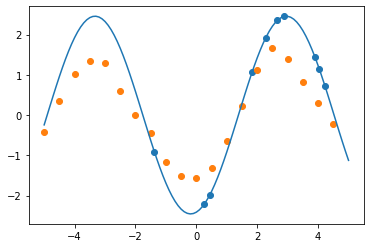

Step 8100: loss = 1.0993334861878499


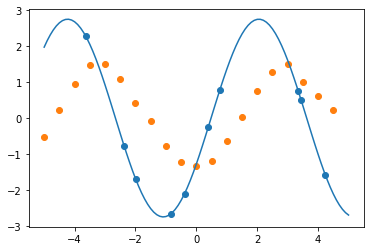

Step 8200: loss = 1.0927848050703297


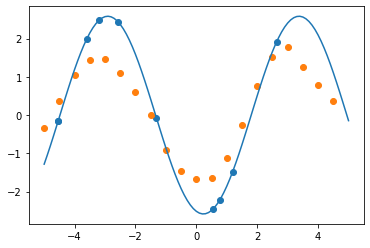

Step 8300: loss = 1.0858320339384637


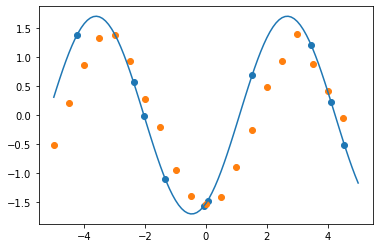

Step 8400: loss = 1.0789027003918694


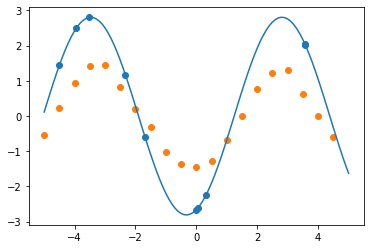

Step 8500: loss = 1.0714191491064593


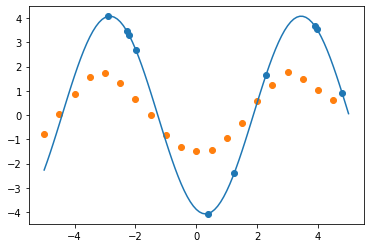

Step 8600: loss = 1.0636814922242417


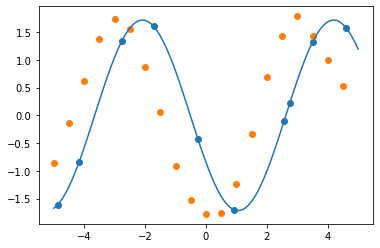

Step 8700: loss = 1.057268528873571


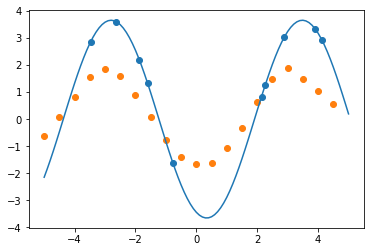

Step 8800: loss = 1.050654948845707


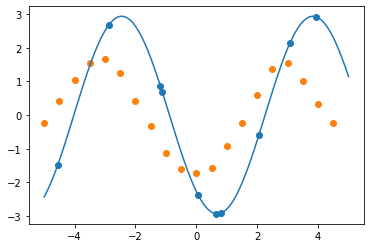

Step 8900: loss = 1.0450434367402022


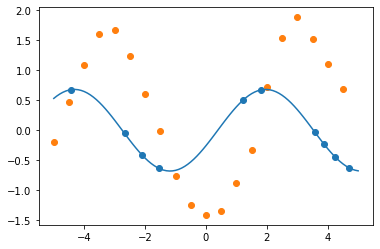

Step 9000: loss = 1.0379424659017513


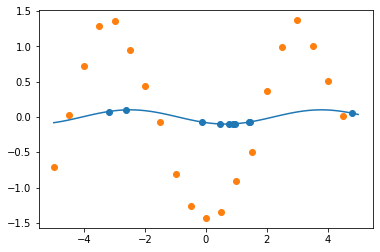

Step 9100: loss = 1.0313257437837018


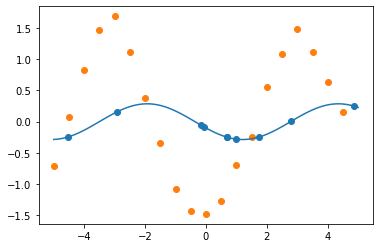

Step 9200: loss = 1.0250540864365596


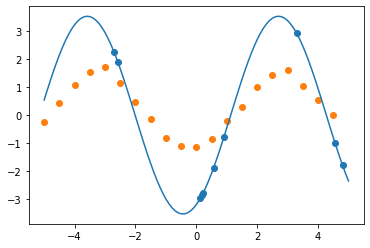

Step 9300: loss = 1.0198176075775154


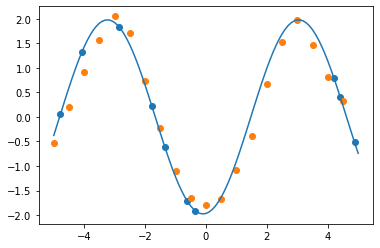

Step 9400: loss = 1.0137133522168777


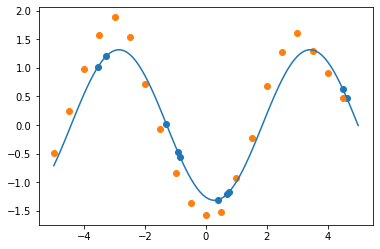

Step 9500: loss = 1.0074252811199031


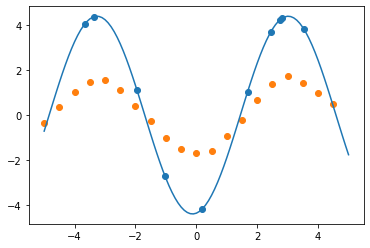

Step 9600: loss = 1.002735583160973


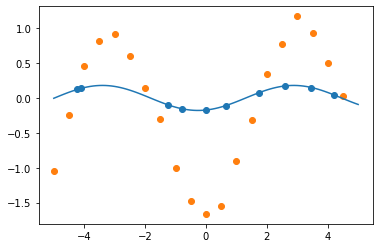

Step 9700: loss = 0.9971046696177377


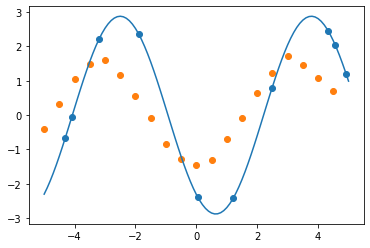

Step 9800: loss = 0.9915428859478294


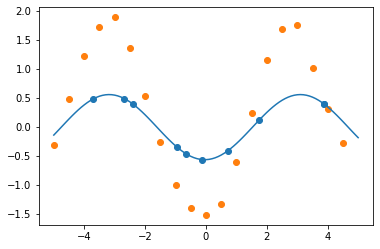

Step 9900: loss = 0.9861369090930797


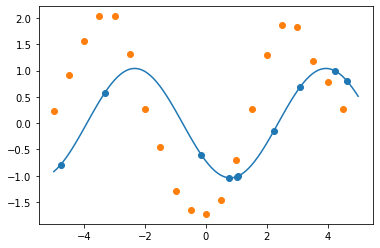

In [ ]:
maml = SineModel()
train_maml(maml, train_ds)

### Test and comparison of the models


We've tested ours models by plotting intermediate results during the training. Now we can test them with new $SinusoidGenerator$ data. The function test_model is able to test both neural_net and maml. Like in the article, we wish to get the result after training a new task (the testing data) with 0, 1 and 10 gradient descent updates. 

In [ ]:
def test_model(model, name, sinusoid_generator=None, num_steps=(0, 1, 10), lr=0.01):
        
    x_test = np.linspace(-5,5,101)
    x_test, y_test = sinusoid_generator.x_y_sample(x_test)
    tensor_x_test, tensor_y_test = tf.convert_to_tensor((x_test, y_test))
    
    x, y = sinusoid_generator.x_y_sample()

    copied_model = copy_model(model, x)


    optimizer = keras.optimizers.Adam(learning_rate=lr)
    
    fit_res = []
    
    if 0 in num_steps:
        y_pred = model.forward(tensor_x_test)
        loss = loss_function(tensor_y_test, y_pred)
        fit_res.append((0, y_pred, loss))
        
    for step in range(1, np.max(num_steps) + 1):
        train_sample(x, y, model, optimizer)

        y_pred = model.forward(tensor_x_test)
        loss = loss_function(tensor_y_test, y_pred)

        if step in num_steps:
            fit_res.append((step, y_pred,loss))   

    plt.plot(x, y, '^', label = 'Training points')

    x_linspace = np.linspace(-5,5,101)
    plt.plot(x_linspace, sinusoid_generator.f(x_linspace), label = 'True function')

    for n, res, loss in fit_res:
        plt.plot(x_test, res[:, 0], '--', label = 'After ' + str(n) + ' steps')
    plt.legend(loc='lower right')
    plt.title(name)

    plt.show()

    return fit_res
    


We can now run the test function for our two models. We want to display as well the loss during the training of a new task. The result shows clearly the fastness of learning for MAML compared to the classic neural network, even with only one training step. 

In [ ]:
def compare_maml_and_neural_net(maml, neural_net, sinusoid_generator, num_steps=list(range(10))):

    fit_maml = test_model(maml, 'MAML', sinusoid_generator)
    fit_neural_net = test_model(neural_net, 'Neural network', sinusoid_generator)
    
    fit_res = {'MAML': fit_maml, 'Neural Net': fit_neural_net}
    
    for fit, label in [(fit_maml, 'MAML'), (fit_neural_net, 'Neural network')]:
        n_iter = []
        loss_iter = []
        for n, _, loss in fit:
            n_iter.append(n)
            loss_iter.append(loss)
        plt.plot(n_iter, loss_iter, marker='o', linestyle='--', label = label)

        plt.xticks(num_steps)
    plt.legend(loc='lower right')
    plt.title("Comparison of loss functions")
    plt.show()

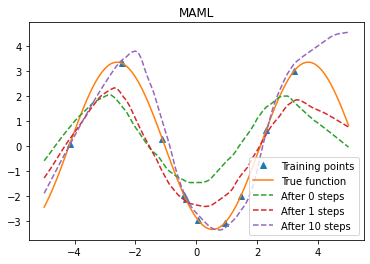

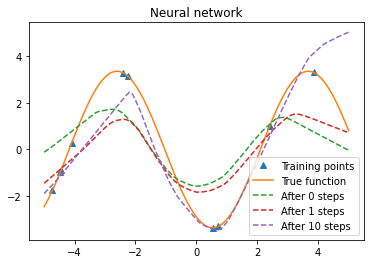

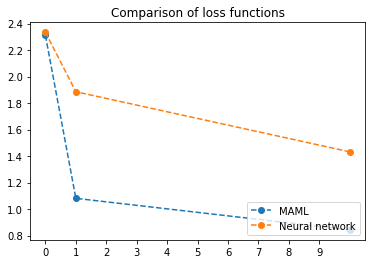

In [ ]:
    sine_wave = SinusoidGenerator()
    compare_maml_and_neural_net(maml, neural_net, sine_wave)